# COMPASS Caggle Notebook

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import imblearn

import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import scikitplot as skplt

from IPython.display import display
import pickle

pd.set_option('display.max_columns', None)

## Helper Functions

In [2]:
def import_data():
    X_train = pd.read_csv('./train/X_train.csv')
    X_test = pd.read_csv('./test/X_test.csv')
    y_train = pd.read_csv('./train/y_train.csv')
    y_test = pd.read_csv('./test/y_test.csv')
    return X_train, X_test, y_train, y_test

def date_difference(start,end):
    start = pd.to_datetime(start).dt.date
    end  = pd.to_datetime(end).dt.date
    return (end-start).dt.days.fillna(-1).astype(int)+1

def modelling(model,X_train,y_train):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(model.score(X_test,y_test))
    print(classification_report(y_test,y_pred))
    df = (pd.DataFrame(zip(X_train.columns,model.feature_importances_)
             ,columns =['feature','importance']).sort_values(by='importance',ascending=False).head(10))
    display(df)
    
    fig,ax=plt.subplots(ncols=2,figsize = (16,6))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax = ax[1])
    skplt.metrics.plot_roc(y_test,y_prob,ax=ax[0])
    plt.show()
    return model

def xgb_model(dtrain, dtest, param, num_round, y_test):
    
    bst = xgb.train(param, dtrain, num_round,
                    evals=[(dtrain, 'train'), (dtest, 'valid')], 
                    early_stopping_rounds=10, verbose_eval=False, )
    
    y_prob = bst.predict(dtest)
    y_pred = np.argmax(y_prob,axis=1)
    
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    
    #Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
    df = pd.DataFrame.from_dict(bst.get_score(importance_type= 'gain'),orient='index').head(10)
    display(df)
    
    fig,ax=plt.subplots(ncols=2,figsize = (16,6))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax = ax[1])
    skplt.metrics.plot_roc(y_test,y_prob,ax=ax[0])
    plt.show()
    return bst

## Load Data

In [3]:
X_train, X_test, y_train, y_test = import_data()

In [4]:
X_train.shape

(3794, 29)

In [5]:
X_train.head(5).T

,0,1,2,3,4
id,2677,548,4483,9476,199
name,nicholas staggewise,newton smith,terrance irvin,jaimie peterson,ritesh sukhlall
first,nicholas,newton,terrance,jaimie,ritesh
last,staggewise,smith,irvin,peterson,sukhlall
sex,Male,Male,Male,Female,Male
date_of_birth,1994-02-28,1995-01-28,1984-04-10,1986-01-02,1987-05-12
age,22,21,32,30,28
age_group,Less than 25,Less than 25,25 - 45,25 - 45,25 - 45
race,Caucasian,African-American,African-American,African-American,Caucasian
juv_fel_count,0,0,0,0,0


## Feature Engineering

### Month out of jail

In [6]:
#X_train['out_month'] = X_train['out_custody'].fillna('0-13-0').str.split('-').apply(lambda x:x[1])

### More Age Bins

In [7]:
X_train['age_group'], bins = pd.qcut(X_train['age'],10,retbins=True)
X_test['age_group'] = pd.cut(X_test["age"], bins=bins, include_lowest=True)

In [8]:
X_train['age_group']=X_train['age_group'].astype(str).str.replace('(','').str.replace(']','').str.replace(', ','-')
X_test['age_group']=X_test['age_group'].astype(str).str.replace('(','').str.replace(']','').str.replace(', ','-')

In [9]:
X_train['age_group'].value_counts()

17.999-23.0    518
27.0-30.0      440
33.0-37.0      398
47.4-54.0      381
54.0-83.0      378
41.0-47.4      369
23.0-25.0      346
30.0-33.0      343
25.0-27.0      317
37.0-41.0      304
Name: age_group, dtype: int64

In [10]:
X_test['age_group'].value_counts()

17.999-23.0    130
33.0-37.0      110
54.0-83.0       96
27.0-30.0       95
30.0-33.0       93
47.4-54.0       93
23.0-25.0       89
41.0-47.4       84
37.0-41.0       80
25.0-27.0       79
Name: age_group, dtype: int64

### Time in Jail

In [11]:
X_train['c_time']=date_difference(X_train['c_jail_in'],X_train['c_jail_out'])
X_train['r_time']=date_difference(X_train['r_jail_in'],X_train['r_jail_out'])

In [12]:
X_test['c_time']=date_difference(X_test['c_jail_in'],X_test['c_jail_out'])
X_test['r_time']=date_difference(X_test['r_jail_in'],X_test['r_jail_out'])

### Charges (See Charges Clustering Notebook)

In [13]:
charge_map = pickle.load(open('charge_map_v3.pkl', 'rb'))

## Preprocessing

In [14]:
drop = ['id', 'name', 'first', 'last',  'date_of_birth', 'age',
        'c_jail_in', 'c_jail_out', 'c_offense_date', 'c_arrest_date',
       'r_jail_in', 'r_jail_out',
       'type_of_assessment', 'screening_date', 'v_type_of_assessment',
       'v_screening_date', 'in_custody', 'out_custody', 'start','start','race']

multi_cat =  ['age_group','c_charge_desc']
binary_cat = ['sex','c_charge_degree',]
continuous = ['juv_fel_count', 'juv_misd_count','juv_other_count', 'priors_count','c_time',
              'r_time','priors_count','days_b_screening_arrest']              

In [15]:
X_train.drop(drop,inplace=True,axis=1)
X_test.drop(drop,inplace=True,axis=1)

### Missing Values

In [16]:
X_train.isnull().sum()

sex                          0
age_group                    0
juv_fel_count                0
juv_misd_count               0
juv_other_count              0
priors_count                 0
days_b_screening_arrest    215
c_charge_degree              0
c_charge_desc               12
c_time                       0
r_time                       0
dtype: int64

In [17]:
X_test.isnull().sum()

sex                         0
age_group                   0
juv_fel_count               0
juv_misd_count              0
juv_other_count             0
priors_count                0
days_b_screening_arrest    53
c_charge_degree             0
c_charge_desc               5
c_time                      0
r_time                      0
dtype: int64

In [18]:
mean = X_train['days_b_screening_arrest'].mean()

X_train['days_b_screening_arrest'].fillna(mean,inplace=True)
X_test['days_b_screening_arrest'].fillna(mean,inplace=True)

In [19]:
X_train['c_charge_desc'].fillna('arrest case no charge',inplace=True)
X_test['c_charge_desc'].fillna('arrest case no charge',inplace=True)

### Map Clusters

In [20]:
X_train['c_charge_desc'] = X_train['c_charge_desc'].map(charge_map)
X_test['c_charge_desc'] = X_test['c_charge_desc'].map(charge_map)

In [21]:
X_train['c_charge_desc'].value_counts()

 11    790
-1     632
 4     327
 15    313
 16    313
 5     304
 3     273
 14    143
 2     121
 8      99
 6      82
 0      82
 9      75
 13     68
 7      64
 17     34
 1      29
 10     25
 12     20
Name: c_charge_desc, dtype: int64

### Encoding

In [22]:
oh_enc = OneHotEncoder(drop='first',handle_unknown='error',sparse=False)
label_enc=LabelEncoder()
scaler = StandardScaler()

In [23]:
col_trans = ColumnTransformer([('categorical', oh_enc, multi_cat+binary_cat)], 
                              remainder='passthrough',sparse_threshold=1)

In [24]:
X_train = pd.DataFrame(col_trans.fit_transform(X_train),columns = col_trans.get_feature_names())
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
y_train = label_enc.fit_transform(y_train.iloc[:,0])

In [25]:
X_test = pd.DataFrame(col_trans.transform(X_test),columns = col_trans.get_feature_names())
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
y_test = label_enc.transform(y_test.iloc[:,0])

### Basic Model

0.9072708113804004
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       751
           1       0.89      0.68      0.77       170
           2       0.14      0.04      0.06        28

    accuracy                           0.91       949
   macro avg       0.65      0.57      0.59       949
weighted avg       0.89      0.91      0.89       949



,feature,importance
35,r_time,0.505657
32,priors_count,0.097037
34,c_time,0.088561
33,days_b_screening_arrest,0.062670
28,categorical__x3_M,0.018885
30,juv_misd_count,0.018075
31,juv_other_count,0.016231
2,categorical__x0_27.0-30.0,0.011351
27,categorical__x2_Male,0.011212
20,categorical__x1_11,0.010884


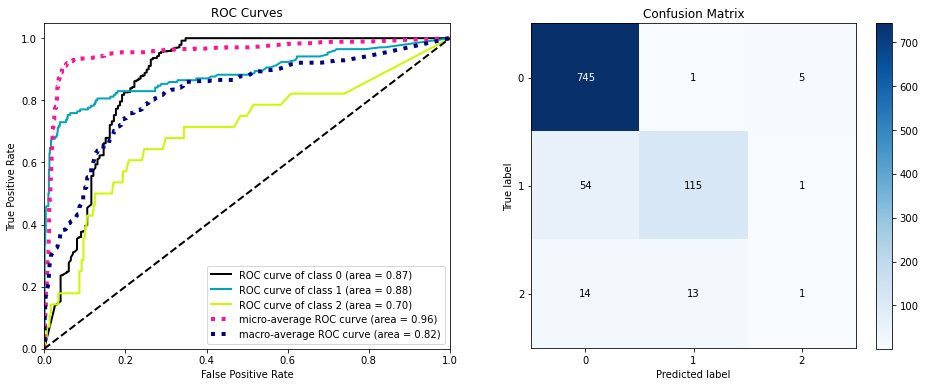

In [26]:
model = RandomForestClassifier(n_estimators=1000,n_jobs=8)
fit_model = modelling(model, X_train, y_train)

### XGBoost

In [27]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [28]:
#dtrain.set_weight([10 if i == 2 else (2 if i == 1 else 1) for i in y_train])

In [29]:
param = {
    'max_depth':10,
    'eta':.1,
    'objective':'multi:softprob',
    'eval_metric':'mlogloss',
    'num_class':3}
num_round = 200

0.9125395152792413
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       751
           1       0.89      0.68      0.77       170
           2       0.50      0.11      0.18        28

    accuracy                           0.91       949
   macro avg       0.77      0.59      0.63       949
weighted avg       0.90      0.91      0.90       949



,0
r_time,23.605631
priors_count,0.741297
juv_misd_count,0.598208
juv_other_count,0.481988
days_b_screening_arrest,0.590203
c_time,0.610234
categorical__x0_23.0-25.0,0.542656
categorical__x0_27.0-30.0,0.635231
categorical__x0_25.0-27.0,0.401970
categorical__x0_30.0-33.0,0.526034


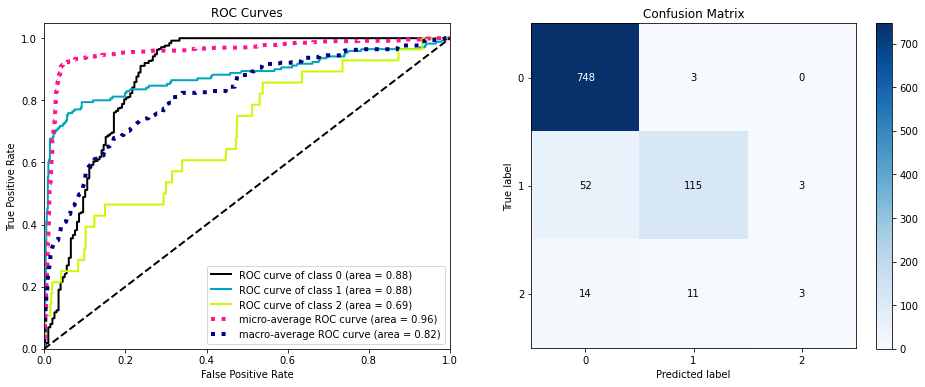

In [30]:
fit_model = xgb_model(dtrain=dtrain, dtest=dtest, param=param, num_round=num_round, y_test=y_test)

## Oversampling

### Using Imblearn

In [31]:
pd.DataFrame(y_train).value_counts()

0    2997
1     649
2     148
dtype: int64

In [32]:
oversample = imblearn.over_sampling.ADASYN(sampling_strategy={0:2997,1:2997,2:2997},n_neighbors=6)
X, y = oversample.fit_resample(X_train, y_train)
pd.DataFrame(y).value_counts()

2    3007
0    2997
1    2918
dtype: int64

In [33]:
#oversample = imblearn.over_sampling.SMOTE(sampling_strategy={0:2997,1:2997,2:2997})
#X, y = oversample.fit_resample(X_train, y_train)
#pd.DataFrame(y).value_counts()

In [34]:
#rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={0:650})
#X, y = rus.fit_resample(X_train, y_train)
#pd.DataFrame(y).value_counts()

### Oversampled Model

In [35]:
dtrain = xgb.DMatrix(data=X,label=y)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [49]:
param = {
    'eta':.05,
    'objective':'multi:softprob',
    'num_class':3,
    'max_depth':3,
    'eval_metric':'mlogloss',
    'min_child_weight':15
}
num_round = 200

0.9051633298208641
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       751
           1       0.90      0.64      0.75       170
           2       0.21      0.11      0.14        28

    accuracy                           0.91       949
   macro avg       0.68      0.58      0.62       949
weighted avg       0.89      0.91      0.89       949



,0
r_time,149.046008
priors_count,32.660857
days_b_screening_arrest,14.050813
c_time,17.164163
categorical__x0_23.0-25.0,22.153533
categorical__x1_11,26.832393
categorical__x0_54.0-83.0,14.158383
categorical__x1_5,19.741036
juv_misd_count,28.635870
categorical__x0_25.0-27.0,16.619421


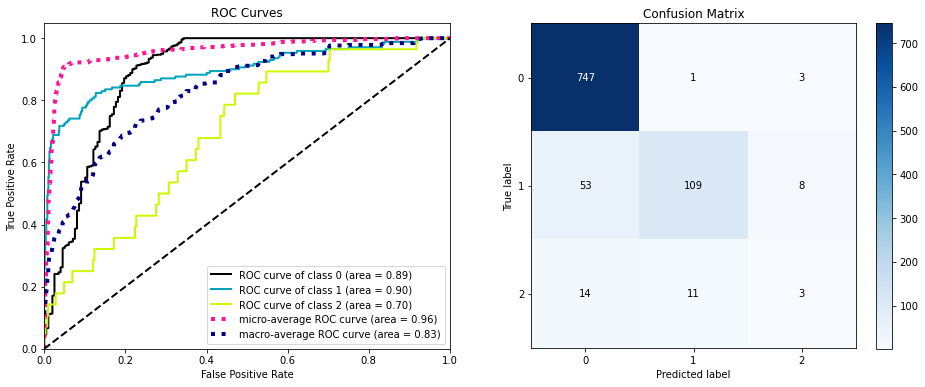

In [50]:
fit_model_2 = xgb_model(dtrain=dtrain, dtest=dtest, param=param, num_round = num_round, y_test=y_test)

## Output Results

In [51]:
results = pd.DataFrame(fit_model_2.predict(dtest),columns=['No-Recidivism','Non-Violent','Violent'])
results.to_csv('results.csv',index=False)